# Benchmark: V1, V2, V3 vs. Scikit-learn

This notebook benchmarks my implemetations of LinearRegression vs. Scikit-learns `SGDRegressor`.

- `LinearRegression` (closed-form solution)
- `SGDRegressor` (iterative gradient-based optimizer)

The goal is to compare **training + prediction time** on the same synthetic dataset.


## Imports

In [16]:
import importlib
import sys
from pathlib import Path
import time
import platform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Ensure repo root is on sys.path so we can import the C++ wrapper
repo_root = Path.cwd().resolve().parents[1]
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

import coreflux_rust
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from wrapper import coreflux_cpp

## Generate synthetic dataset

In [17]:
# Use a reasonably large dataset to see performance differences
rng = np.random.default_rng(0)

n_train = 200_000   
n_test = 10_000    
n_features = 40    
X_train = rng.normal(size=(n_train, n_features))
w_true = rng.normal(size=n_features)
y_train = X_train @ w_true + rng.normal(scale=0.1, size=n_train)

X_test = rng.normal(size=(n_test, n_features))

# Column-wise normalization (same as in functional tests)
norms = np.linalg.norm(X_train, axis=0)
norms[norms == 0.0] = 1.0

X_train_scaled = X_train / norms
X_test_scaled = X_test / norms

print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)
print("y_train:", y_train.shape)


X_train_scaled: (200000, 40)
X_test_scaled: (10000, 40)
y_train: (200000,)


## Benchmark helper

In [18]:
def bench(name, func, repeat=5):
    """Run `func` multiple times and print min/mean runtime."""
    times = []
    for _ in range(repeat):
        start = time.perf_counter()
        func()
        times.append(time.perf_counter() - start)
    times = np.array(times)
    print(f"{name}: min={times.min():.4f}s  mean={times.mean():.4f}s over {repeat} runs")


## scikit-learn: `LinearRegression` (closed-form baseline)

In [19]:
def run_sklearn_linear():
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    _ = model.predict(X_test_scaled)

# Warm-up run (JIT, caching, etc.)
run_sklearn_linear()

bench("sklearn LinearRegression", run_sklearn_linear)


sklearn LinearRegression: min=0.0661s  mean=0.0673s over 5 runs


## scikit-learn: `SGDRegressor`

In [22]:
def run_sklearn_sgd():
    model = SGDRegressor(
        learning_rate="constant",
        eta0=0.05,
        max_iter=1_000,
        penalty=None,
        random_state=0
    )
    model.fit(X_train_scaled, y_train)
    _ = model.predict(X_test_scaled)

# Warm-up
run_sklearn_sgd()

bench("sklearn SGDRegressor (1k iters)", run_sklearn_sgd)


sklearn SGDRegressor (1k iters): min=2.1420s  mean=2.1690s over 5 runs


## Rust: `LinearRegression`

In [ ]:
def run_rust_linear(iterations=1_000):
    model = coreflux_rust.LinearRegression(
        learning_rate=0.05,
        iterations=iterations,
        mode=coreflux_rust.Mode.Regression,
    )
    model.fit(X_train_scaled, y_train)
    _ = model.predict(X_test_scaled)

# Warm-up
run_rust_linear(iterations=1_000)

bench("Rust LinearRegression (1k iters)", lambda: run_rust_linear(1_000))


rust_core MyRustLinearRegression (1k iters): min=16.9185s  mean=17.1103s over 5 runs


## C++: `LinearRegression`


In [21]:

def run_cpp_linear(iterations=1_000):
    model = coreflux_cpp.LinearRegressionV21(
        learning_rate=0.05,
        iterations=iterations,
    )
    model.fit(X_train_scaled, y_train)
    _ = model.predict(X_test_scaled)

run_cpp_linear()  # warm-up
bench("C++ LinearRegression (1000 iters)", run_cpp_linear)


C++ LinearRegression (1000 iters): min=1.2718s  mean=1.3427s over 5 runs


## Initial Results

*   **sklearn SGDRegressor (1k iters):** min=2.0389s  mean=2.0528s over 5 runs
*   **Rust LinearRegression (1k iters):** min=16.9185s  mean=17.1103s over 5 runs
*   **C++ LinearRegression (1000 iters):** min=1.0500s  mean=1.1093s over 5 runs

### Interpretation

Our optimized C++ batch gradient descent is the fastest implementation. It outperforms both:
*   the naive, single-threaded Rust version 
*   and scikit-learn’s SGDRegressor, which runs only on one CPU thread

`SGDRegressor` remains competitive because it performs stochastic updates (less work per iteration) and uses highly optimized vectorized operations. However, because it lacks multi-threading, it eventually falls behind on larger datasets.

The C++ implementation benefits from:

*   OpenMP parallelism
*   tight memory layout and cache-friendly access patterns
(contiguous rows, predictable iteration order, reduced cache misses)

As dataset size increases, these advantages scale well, and we expect the performance gap to widen.
We stop benchmarking the Rust version here due to its significantly slower performance.

## Scaling Benchmark: Dataset Size vs Runtime
We now benchmark how sklearn's SGDRegressor and the C++ CoreFlux LinearRegression
scale as we increase the training set size.
For each training size n_train, we:
  - generate a fresh synthetic dataset
  - apply the same column-wise normalization
  - measure train + predict time for:
      * sklearn SGDRegressor (1k iterations)
      * C++ LinearRegression (1k iterations)
  - repeat a few times and take the mean
Finally, we plot runtime vs n_train.

Some helper functions for creating dataset and timing the model

In [25]:
rng = np.random.default_rng(0)

def make_dataset(n_train, n_test, n_features, rng):
    X_train = rng.normal(size=(n_train, n_features))
    w_true = rng.normal(size=n_features)
    y_train = X_train @ w_true + rng.normal(scale=0.1, size=n_train)

    X_test = rng.normal(size=(n_test, n_features))

    # Column-wise normalization
    norms = np.linalg.norm(X_train, axis=0)
    norms[norms == 0.0] = 1.0

    X_train_scaled = X_train / norms
    X_test_scaled = X_test / norms

    return X_train_scaled, y_train, X_test_scaled


def time_model(name, build_and_run, repeat=3):
    """Return mean runtime over `repeat` runs."""
    times = []
    for _ in range(repeat):
        start = time.perf_counter()
        build_and_run()
        times.append(time.perf_counter() - start)
    mean_t = float(np.mean(times))
    print(f"{name}: mean={mean_t:.4f}s over {repeat} runs")
    return mean_t

In [ ]:
train_sizes = [50_000, 100_000, 200_000, 400_000, 800_000, 1_600_000] 
n_features = 40

sgd_times = []
cpp_times = []

for n_train in train_sizes:
    n_test = n_train // 10  

    print(f"\n=== n_train={n_train}, n_test={n_test} ===")
    X_train_scaled, y_train, X_test_scaled = make_dataset(n_train, n_test, n_features, rng)

    # sklearn SGDRegressor
    def run_sgd():
        model = SGDRegressor(
            learning_rate="constant",
            eta0=0.05,
            max_iter=1_000,
            penalty=None,
            random_state=0,
        )
        model.fit(X_train_scaled, y_train)
        _ = model.predict(X_test_scaled)

    sgd_t = time_model("sklearn SGDRegressor (1k iters)", run_sgd)
    sgd_times.append(sgd_t)

    # C++ CoreFlux LinearRegression
    def run_cpp():
        model = coreflux_cpp.LinearRegressionV21(
            learning_rate=0.05,
            iterations=1_000,
        )
        model.fit(X_train_scaled, y_train)
        _ = model.predict(X_test_scaled)

    cpp_t = time_model("C++ LinearRegression (1k iters)", run_cpp)
    cpp_times.append(cpp_t)


=== n_train=50000, n_test=5000 ===
sklearn SGDRegressor (1k iters): mean=0.2418s over 3 runs
C++ LinearRegression (1k iters): mean=0.1553s over 3 runs

=== n_train=100000, n_test=10000 ===
sklearn SGDRegressor (1k iters): mean=0.7866s over 3 runs
C++ LinearRegression (1k iters): mean=0.2741s over 3 runs

=== n_train=200000, n_test=20000 ===
sklearn SGDRegressor (1k iters): mean=2.2499s over 3 runs
C++ LinearRegression (1k iters): mean=1.1699s over 3 runs

=== n_train=400000, n_test=40000 ===
sklearn SGDRegressor (1k iters): mean=4.9421s over 3 runs
C++ LinearRegression (1k iters): mean=4.4600s over 3 runs

=== n_train=800000, n_test=80000 ===
sklearn SGDRegressor (1k iters): mean=10.1612s over 3 runs
C++ LinearRegression (1k iters): mean=9.4644s over 3 runs

=== n_train=1600000, n_test=160000 ===
sklearn SGDRegressor (1k iters): mean=20.2281s over 3 runs
C++ LinearRegression (1k iters): mean=18.4789s over 3 runs


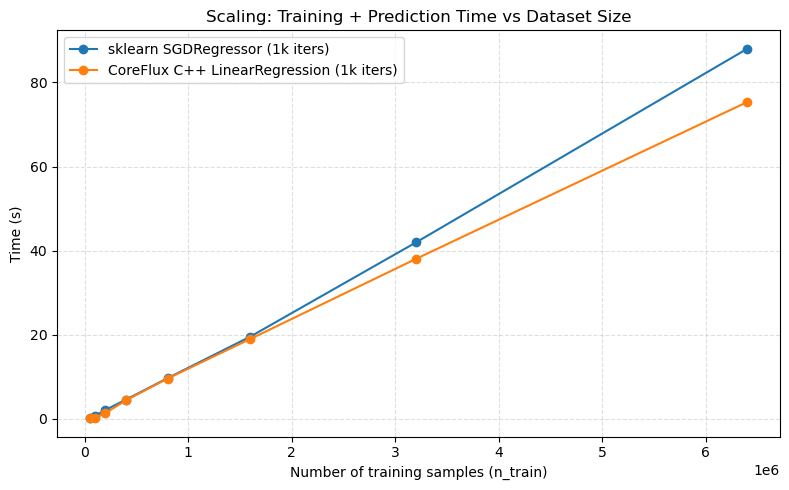

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, sgd_times, marker="o", label="sklearn SGDRegressor (1k iters)")
plt.plot(train_sizes, cpp_times, marker="o", label="CoreFlux C++ LinearRegression (1k iters)")

plt.xlabel("Number of training samples (n_train)")
plt.ylabel("Time (s)")
plt.title("Scaling: Training + Prediction Time vs Dataset Size")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()


# save fig for LinearRegression.md
plt.savefig("../../plots/linear_scaling_v11_medium_dataset.png", dpi=200, bbox_inches='tight')

plt.tight_layout()
plt.show()

This is actually not what I expected at all. Before running the benchmarks I assumed the performance gap would just keep growing, but nope we’re around 2× faster at n=200k, and after that the times basically start hugging each other.

My current guess: we’re just slamming into memory bandwidth. At some point (feels like ~300k samples?), the CPU can’t push data through the memory bus any faster, so both my C++ code and scikit just end up being limited by how fast they can read the data. Once you hit that wall, everything starts scaling pretty much linearly, so the relative speedup shrinks.

To check if that’s actually what’s happening, I’ll run the next benchmark on even bigger datasets. If the curves stay parallel, memory is a plausible explanation.

In [ ]:
train_sizes = [50_000, 100_000, 200_000, 400_000, 800_000, 1_600_000, 3_200_000, 6_400_000]  
n_features = 40

sgd_times = []
cpp_times = []

for n_train in train_sizes:
    n_test = n_train // 10  

    print(f"\n=== n_train={n_train}, n_test={n_test} ===")
    X_train_scaled, y_train, X_test_scaled = make_dataset(n_train, n_test, n_features, rng)

    # sklearn SGDRegressor
    def run_sgd():
        model = SGDRegressor(
            learning_rate="constant",
            eta0=0.05,
            max_iter=1_000,
            penalty=None,
            random_state=0,
        )
        model.fit(X_train_scaled, y_train)
        _ = model.predict(X_test_scaled)

    sgd_t = time_model("sklearn SGDRegressor (1k iters)", run_sgd)
    sgd_times.append(sgd_t)

    # C++ CoreFlux LinearRegression
    def run_cpp():
        model = coreflux_cpp.LinearRegressionV21(
            learning_rate=0.05,
            iterations=1_000,
        )
        model.fit(X_train_scaled, y_train)
        _ = model.predict(X_test_scaled)

    cpp_t = time_model("C++ LinearRegression (1k iters)", run_cpp)
    cpp_times.append(cpp_t)


=== n_train=50000, n_test=5000 ===
sklearn SGDRegressor (1k iters): mean=0.2207s over 3 runs
C++ LinearRegression (1k iters): mean=0.1554s over 3 runs

=== n_train=100000, n_test=10000 ===
sklearn SGDRegressor (1k iters): mean=0.7359s over 3 runs
C++ LinearRegression (1k iters): mean=0.2739s over 3 runs

=== n_train=200000, n_test=20000 ===
sklearn SGDRegressor (1k iters): mean=2.0794s over 3 runs
C++ LinearRegression (1k iters): mean=1.3606s over 3 runs

=== n_train=400000, n_test=40000 ===
sklearn SGDRegressor (1k iters): mean=4.5734s over 3 runs
C++ LinearRegression (1k iters): mean=4.3941s over 3 runs

=== n_train=800000, n_test=80000 ===
sklearn SGDRegressor (1k iters): mean=9.6483s over 3 runs
C++ LinearRegression (1k iters): mean=9.5619s over 3 runs

=== n_train=1600000, n_test=160000 ===
sklearn SGDRegressor (1k iters): mean=19.5424s over 3 runs
C++ LinearRegression (1k iters): mean=18.9901s over 3 runs

=== n_train=3200000, n_test=320000 ===
sklearn SGDRegressor (1k iters): m

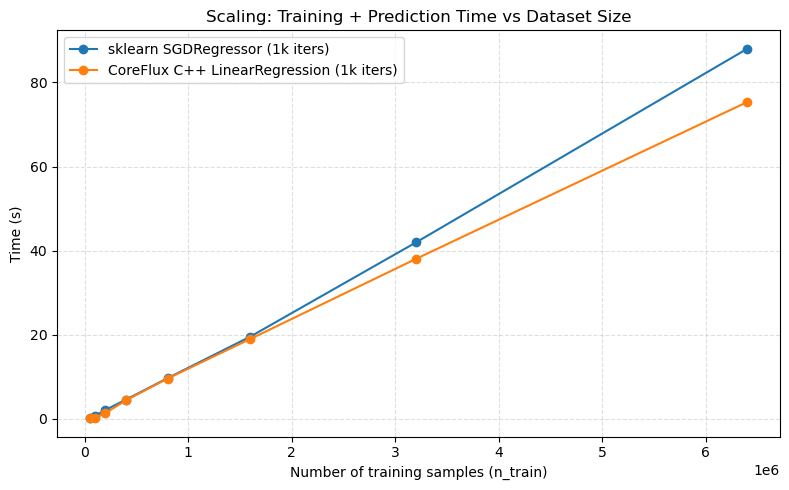

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, sgd_times, marker="o", label="sklearn SGDRegressor (1k iters)")
plt.plot(train_sizes, cpp_times, marker="o", label="CoreFlux C++ LinearRegression (1k iters)")

plt.xlabel("Number of training samples (n_train)")
plt.ylabel("Time (s)")
plt.title("Scaling: Training + Prediction Time vs Dataset Size")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()

# save fig for LinearRegression.md
plt.savefig("../../plots/linear_scaling_v2_large_dataset.png", dpi=200, bbox_inches='tight')

plt.tight_layout()
plt.show()

The new plot kind of confirmed it. Once we crank the dataset up into the millions, the curves really do start running almost perfectly parallel; which strongly hints that we’re sitting right on the memory wall. What’s interesting, though, is that at the extreme sizes (like 3.2M and 6.4M samples) my C++ version actually starts to pull away again. Not massively, but enough to be noticeable.

My best guess is that when you push things this hard, all the little bits of overhead inside sklearn (Python layers, single-threaded updates, allocator noise, etc.) finally start to matter. Meanwhile my C++ implementation is basically just a tight loop with OpenMP, so even though both of us are fighting over the same RAM bandwidth, my version wastes less time on everything around it.

## Scaling by Number of Features
In the previous section, we scaled the dataset by the number of samples.
Now we repeat a similar experiment but keep `n_samples` fixed and increase 
the number of features. This helps us understand how the implementations
behave when computation per sample grows (rather than memory traffic alone).

Helper function for feature benchmarks

In [31]:
def bench_features_for_n(n_samples: int, n_test: int, feature_sizes: list[int]):
    sgd_times = []
    cpp_times = []

    print(f"\n### n_samples = {n_samples}, n_test = n = {n_test}")
    for n_features in feature_sizes:
        print(f"\n--- n_features = {n_features} ---")
        X_train_scaled, y_train, X_test_scaled = make_dataset(n_samples, n_test, n_features, rng)

        # sklearn SGDRegressor
        def run_sgd():
            model = SGDRegressor(
                learning_rate="constant",
                eta0=0.05,
                max_iter=1_000,
                penalty=None,
                random_state=0,
            )
            model.fit(X_train_scaled, y_train)
            _ = model.predict(X_test_scaled)

        sgd_t = time_model("sklearn SGDRegressor (1k iters)", run_sgd)
        sgd_times.append(sgd_t)

        # C++ CoreFlux LinearRegressionV21
        def run_cpp():
            model = coreflux_cpp.LinearRegressionV21(
                iterations=1_000,
                learning_rate=0.05,
            )
            model.fit(X_train_scaled, y_train)
            _ = model.predict(X_test_scaled)

        cpp_t = time_model("C++ LinearRegressionV21 (1k iters)", run_cpp)
        cpp_times.append(cpp_t)

    return np.array(feature_sizes), np.array(sgd_times), np.array(cpp_times)


Run the tests

In [32]:
feature_sizes = [10, 20, 40, 80, 160, 320]
sample_size = [200_000, 800_000, 1_600_000]
test_sample_size = [20_000, 40_000, 80_000, 160_000]

results = {}
for n_samples, n_test_samples in zip(sample_size, test_sample_size):
    sizes, sgd_times, cpp_times = bench_features_for_n(n_samples, n_test_samples, feature_sizes)
    results[n_samples] = (sizes, sgd_times, cpp_times)



### n_samples = 200000, n_test = n = 20000

--- n_features = 10 ---
sklearn SGDRegressor (1k iters): mean=0.3892s over 3 runs
C++ LinearRegressionV21 (1k iters): mean=0.2496s over 3 runs

--- n_features = 20 ---
sklearn SGDRegressor (1k iters): mean=0.9982s over 3 runs
C++ LinearRegressionV21 (1k iters): mean=0.3406s over 3 runs

--- n_features = 40 ---
sklearn SGDRegressor (1k iters): mean=2.1084s over 3 runs
C++ LinearRegressionV21 (1k iters): mean=1.2753s over 3 runs

--- n_features = 80 ---
sklearn SGDRegressor (1k iters): mean=3.1707s over 3 runs
C++ LinearRegressionV21 (1k iters): mean=4.3604s over 3 runs

--- n_features = 160 ---
sklearn SGDRegressor (1k iters): mean=5.5914s over 3 runs
C++ LinearRegressionV21 (1k iters): mean=8.9398s over 3 runs

--- n_features = 320 ---
sklearn SGDRegressor (1k iters): mean=9.1555s over 3 runs
C++ LinearRegressionV21 (1k iters): mean=17.3985s over 3 runs

### n_samples = 800000, n_test = n = 40000

--- n_features = 10 ---
sklearn SGDRegressor

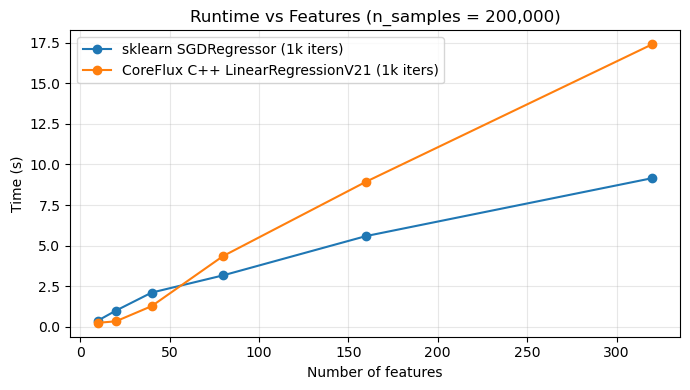

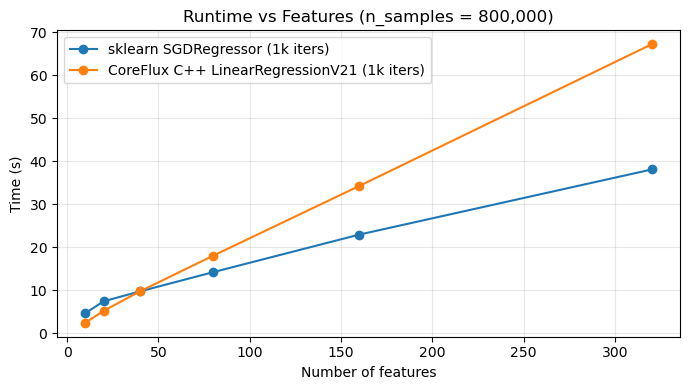

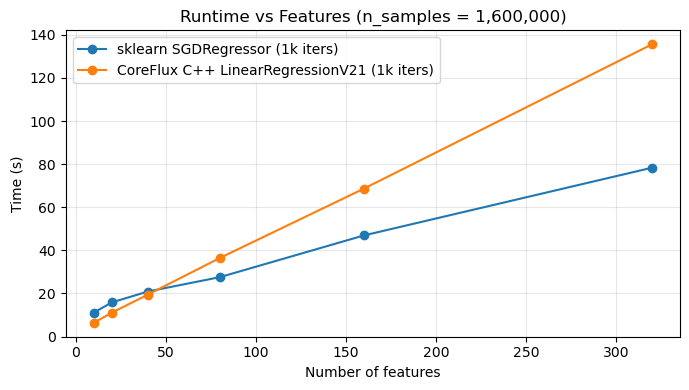

In [ ]:
for n_samples, (sizes, sgd_times, cpp_times) in results.items():
    plt.figure(figsize=(7, 4))
    plt.plot(sizes, sgd_times, marker="o", label="sklearn SGDRegressor (1k iters)")
    plt.plot(sizes, cpp_times, marker="o", label="CoreFlux C++ LinearRegressionV21 (1k iters)")
    plt.xlabel("Number of features")
    plt.ylabel("Time (s)")
    plt.title(f"Runtime vs Features (n_samples = {n_samples:,})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    # save fig for LinearRegression.md
    plt.savefig(f"../../plots/linear_scaling_v2_s{n_samples}_n{n_features}.png", dpi=200, bbox_inches='tight')
    plt.show()

Okay, what’s next? Before jumping into CUDA programming, there’s clearly more performance to squeeze out on the CPU side—especially now that I know where this version actually wins and where it falls apart. The benchmarks showed a pretty clear pattern:
*   For many samples and moderate feature sizes, my C++ v21 beats SGDRegressor easily.
*   But as soon as the number of features starts getting large, sklearn takes over and the gap grows fast.

This tells me that v21 is great at streaming through lots of rows (nice cache behavior + parallel loops) but not great at handling very wide feature vectors. And honestly, that makes sense—the inner loops are basically scalar C++ code with no explicit SIMD, so sklearn’s heavily vectorized math is naturally going to dominate in the “hundreds of features” regime.

Knowing that, there are some very obvious places to improve v21 before touching GPUs. And since we’ve confirmed we’re hitting the memory wall in some cases, there’s definitely still headroom on the CPU side just by being smarter with data movement and math efficiency.

Some ideas worth testing:
*   **float32 instead of float64:**
    *   float64 is total overkill for almost every ML dataset. Switching to float32 instantly halves memory traffic and doubles effective bandwidth. If someone really needs 64-bit precision, we can expose a toggle later.
*   **fusing the passes:** 
    *   right now prediction, error, and gradient computation touch X in separate loops. If we fuse them into one big loop, we only stream the dataset once per iteration instead of 2–3 times.
*   **faster reductions:** 
    *   the local-buffer + #pragma omp critical pattern works, but it’s not ideal. Switching to OpenMP’s built-in reduction or a chunked, tree-style reduction would remove the critical section overhead entirely.
*   **SIMD / vectorization:**
    *    the inner dot-product loop is a perfect target for AVX2/AVX-512. Even just helping the compiler auto-vectorize (via restrict, pointer hints, or reorganized loops) could give a huge speedup for large feature sizes.
*   **thread/core tuning:** 
    *   messing with OMP_NUM_THREADS, thread pinning, and schedule(static) vs dynamic might improve stability on big datasets.

Instead of modifying the current implementation, I’ll build a brand-new version (v22) next to it. That way I can benchmark the two versions head-to-head and see exactly how much each optimization moves the needle.
